# Dynamic Mode Decomposition
In this textbook example, we show how `kooplearn` can produce the dynamic mode decomposition of a fluid flow with very little effort. We will use data from [FlowBench](https://huggingface.co/datasets/BGLab/FlowBench/tree/main) of a fluid flow past an object. First we download and display the data:

In [ ]:
import urllib.request
import os

# Base URL for raw file downloads
base_url = "https://huggingface.co/datasets/BGLab/FlowBench/resolve/main/FPO_NS_2D_1024x256/harmonics/92/"

# List the exact filenames you want to download
filenames = [
    "input_geometry.npz",
    "Re_411.npz",  # Simulations at Reynolds number 411
]

print(f"Starting download from: {base_url}")

for fname in filenames:
    file_url = base_url + fname
    local_path = os.path.join(".", fname)  # Saves to the current directory

    # Check if the file already exists
    if os.path.exists(local_path):
        print(f"File already exists: {local_path}. Skipping.")
        continue  # Move to the next file

    # Proceed with download if it doesn't exist
    try:
        print(f"Downloading: {fname}...")
        # urlretrieve(source_url, destination_path)
        urllib.request.urlretrieve(file_url, local_path)
        print(f"Successfully saved to: {local_path}")
    except Exception as e:
        print(f"Failed to download {fname}: {e}")

print("All downloads finished.")

In [4]:
import numpy as np
import matplotlib.pyplot as plt

SUBSAMPLE = 4
flow = np.load("Re_411.npz")

X = flow["data"][:,::SUBSAMPLE, ::SUBSAMPLE, :]
geometry = np.load("input_geometry.npz")["mask"][::SUBSAMPLE, ::SUBSAMPLE]

def plot_flow(X, ax, time_id=0, streamplot: bool = True):
    u = X[..., 0]
    v = X[..., 1]
    p = X[..., 2]
    x, y = np.meshgrid(
        np.linspace(0, 5, 1024)[::SUBSAMPLE],
        np.linspace(0, 1, 256)[::SUBSAMPLE],
    )
    ax.set_aspect("equal")
    masked_pressure = np.where(
        geometry, p[time_id], np.nan
    )
    _ = ax.contourf(x, y, masked_pressure, 100, cmap="Spectral")
    if streamplot:
        ax.streamplot(
            x, y, u[time_id], v[time_id], color="black", linewidth=0.2, arrowsize=0.2
        )
    ax.set_axis_off()
    return ax

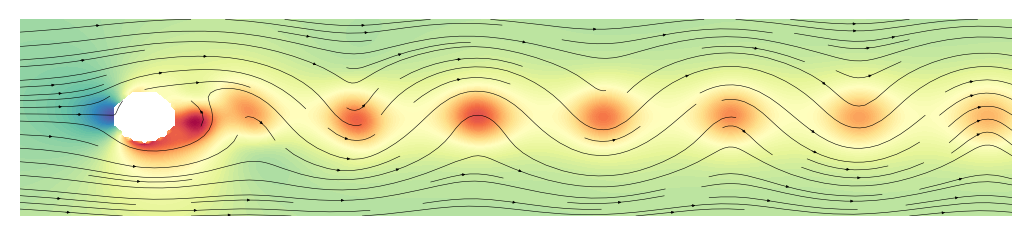

In [5]:
fig, ax = plt.subplots(dpi=200)
ax = plot_flow(X, ax)

## Dynamic Mode Decomposition 

`kooplearn` estimators have a convenient `.dynamical_modes` method which returns the Koopman mode decomposition. The original dynamic mode decomposition assumed a linear dynamics, and we will do the same in this notebook. First we properly scale and flatten the data using `sklearn`-compatible transformations:

In [6]:
from kooplearn.preprocessing import FeatureFlattener
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [20]:
# Custom scaler. Can't use sklearn StandardScaler, as it improperly averages over every dimension, while we want to keep the field-wise means and stds separate.
class FlowScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Save shape for inverse_transform
        self.mean_ = np.mean(X, axis =(0, 1, 2), keepdims=True)
        self.std_ = np.std(X, axis =(0, 1, 2), keepdims=True)
        self._is_fitted = True
        return self

    def transform(self, X, y=None):
        _X = (X - self.mean_)/self.std_
        return _X

    def inverse_transform(self, X, y=None):
        _X =  X*self.std_ + self.mean_
        return _X

flattener = FeatureFlattener()
scaler = FlowScaler()
data_pipe = Pipeline([("scaler", scaler),("flattener", flattener)])

We can now fit a kooplearn estimator. We will use the `KernelRidge` class, with a `linear` kernel. The results would be identical to using `kooplearn.linear_model.Ridge`, but the latter is better suited for large number of points and moderate number of dimentions.

In [21]:
from kooplearn.kernel import KernelRidge
model = KernelRidge(n_components=128, reduced_rank=False, alpha=1e-5).fit(data_pipe.fit_transform(X))
# Compute the dynamical modes
dmd = model.dynamical_modes(data_pipe.fit_transform(X))

We can display a handy summary of the fitted model by calling the `summary()` method:

In [15]:
dmd.summary().head()

,frequency,lifetime,eigenvalue_real,eigenvalue_imag,eigenvalue_magnitude,is_stable,is_conjugate_pair
0,0.000000,4.016155e+08,1.000000,0.000000,1.000000,True,False
1,0.044882,2.836224e+04,0.960466,-0.278269,0.999965,True,True
2,0.056141,1.451679e+04,0.938365,-0.345448,0.999931,True,True
3,0.089713,9.749367e+03,0.845205,-0.534251,0.999897,True,True
4,0.033699,2.466430e+03,0.977271,-0.210071,0.999595,True,True


Finally, we can plot the leading modes:

/Users/pietronovelli/code_repos/kooplearn/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


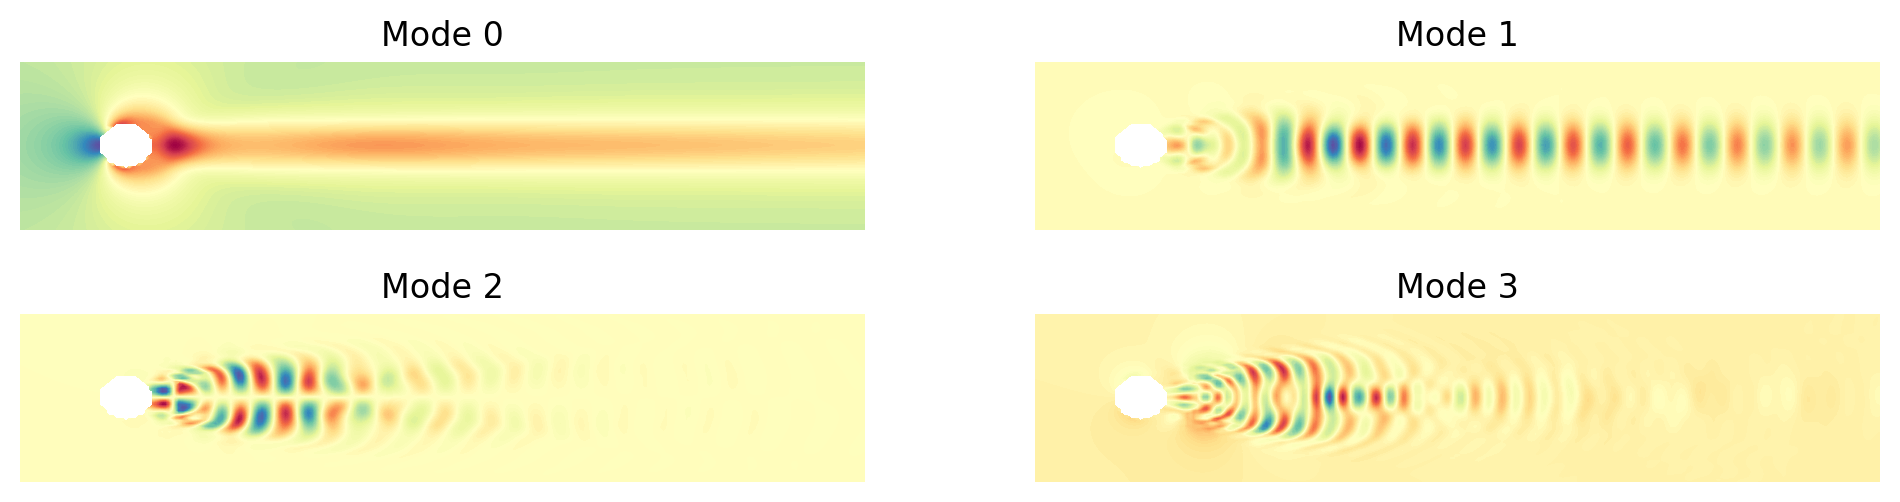

In [22]:
# Some nice plots
t_id = 100
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 3), dpi=200)
for mode_idx, ax in enumerate(axs.flatten()):
    ax = plot_flow(data_pipe.fit(X).inverse_transform(dmd[mode_idx]), ax = ax, streamplot=False)
    ax.set_title(f"Mode {mode_idx}")